In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from efficientkan import KAN

import math
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Load MNIST dataset

transform = transforms.Compose([
    #torchvision.transforms.Resize(14),      # Resize the image
    transforms.ToTensor(),                  # Convert images to PyTorch tensors and scale to [0,1]
    transforms.Normalize((0.5,), (0.5,))    # Normalize to mean=0.5, std=0.5
])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
valset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [3]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

img_res = images.shape[3]

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


In [4]:
class MyMLP(nn.Module):

    def __init__(self, layers: list):
        super(MyMLP, self).__init__()

        self.layers = layers
        to_sequential, self.num_parameters = self.build_layers_and_count_params(layers)
        self.build_layers = nn.Sequential(*to_sequential)

    def forward(self, x):
        return self.build_layers(x)


    # given a list of layer sizes, builds the respective linear layers with ReLU activation functions.
    # Also returns the total number of parameters of the model.
    def build_layers_and_count_params(self, layers):

        to_sequential = []
        num_parameters = 0

        for i in range(len(layers) - 1):

            to_sequential.append(nn.Linear(layers[i], layers[i+1]))
            if i < len(layers)-2:
                to_sequential.append(nn.ReLU())

            num_parameters += layers[i]*layers[i+1] + layers[i+1]

        return to_sequential, num_parameters




class MyKAN(nn.Module):

    def __init__(self, layers: list, grid_size):
        super(MyKAN, self).__init__()

        self.layers = layers
        self.num_parameters = self.count_params(layers, grid_size)
        self.build_layers = KAN(layers, grid_size=grid_size)


    def forward(self, x):
        return self.build_layers(x)


    def count_params(self, layers, grid_size):

        num_parameters = 0

        for i in range(len(layers) - 1):
            num_parameters += layers[i]*layers[i+1]

        return num_parameters * grid_size

In [5]:
def train_and_evaluate(model, trainloader, valloader, device, num_epochs, optimizer, criterion):

    lr = optimizer.param_groups[0]['lr']
    print(f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} and parameters:' if device=='cpu' else f'Training model "{model.__class__.__name__}" {model.layers} with device: {device} ({torch.cuda.get_device_name()}) and parameters:')
    print(f'\tLearning rate: {lr}\n\tLoss function: {criterion}\n\tOptimizer: {optimizer.__class__.__name__}\n')
    print(f'Number of parameters: {model.num_parameters}\n')

    model.to(device)

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    times = []

    for epoch in range(num_epochs):

# Train
        model.train()
        train_loss = 0
        train_acc = 0

        start = time()

        with tqdm(trainloader) as pbar:
            for i, (images, labels) in enumerate(pbar):
                images = images.view(-1, img_res*img_res).to(device)
                optimizer.zero_grad()
                output = model(images)

                loss = criterion(output, labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

                accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
                train_acc += accuracy.item()

        train_losses.append(train_loss / i)
        train_accs.append(train_acc / i)

        t = time()-start
        times.append(t)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / i:.4f}, Train Accuracy: {train_acc / i:.4f}, Time: {t:.2f}s")


# Validation
        model.eval()
        val_loss = 0
        val_acc = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(valloader):
                images = images.view(-1, img_res*img_res).to(device)
                output = model(images)

                val_loss += criterion(output, labels.to(device)).item()
                val_acc += ((output.argmax(dim=1) == labels.to(device)).float().mean().item())

        val_losses.append(val_loss / i)
        val_accs.append(val_acc / i)

        print(f"\t     Valid Loss: {val_loss / i:.4f}, Valid Accuracy: {val_acc / i:.4f}\n")


    return train_losses, train_accs, val_losses, val_accs, times

In [6]:
def build_data_frame(model, num_epochs, train_losses, train_accs, val_losses, val_accs, time, separator):

    df = pd.DataFrame({
        'Epoch': [i for i in range(num_epochs)],
        'Loss (t)': [i for i in train_losses],
        'Loss (v)': [i for i in val_losses],
        'Accuracy (t)': [i for i in train_accs],
        'Accuracy (v)': [i for i in val_accs],
        'Time': [i for i in time]
        })
    
    df = pd.concat([df, pd.DataFrame([{'Epoch': 'Mean', 'Time': df['Time'].mean()}])], ignore_index=True)
    df = pd.concat([df, pd.DataFrame([{'Epoch': f'Params: {model.num_parameters}'}])], ignore_index=True)
    df = pd.concat([df, separator], ignore_index=True)

    return df

In [7]:
# Define models and parameters

model_list_mlp = [
    MyMLP([img_res*img_res, 128, 10]),
    MyMLP([img_res*img_res, 64, 10]),
    MyMLP([img_res*img_res, 10, 10]),
    MyMLP([img_res*img_res, 5, 10]),
    MyMLP([img_res*img_res, 10, 10, 10]),
    MyMLP([img_res*img_res, 5, 5, 10]),
    ]
model_list_kan = [
    MyKAN([img_res*img_res, 128, 10], grid_size=3),
    MyKAN([img_res*img_res, 64, 10], grid_size=3),
    MyKAN([img_res*img_res, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 10], grid_size=3),
    MyKAN([img_res*img_res, 10, 10, 10], grid_size=3),
    MyKAN([img_res*img_res, 5, 5, 10], grid_size=3)
    ]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

num_epochs = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()

df_mlp, df_kan = [pd.DataFrame(columns=['Epoch', 'Loss (t)', 'Loss (v)', 'Accuracy (t)', 'Accuracy (v)', 'Time']) for _ in range(2)]
separator = pd.DataFrame({'Epoch' : ['---'], 'Loss (t)' : ['---'], 'Loss (v)': ['---'], 'Accuracy (t)': ['---'], 'Accuracy (v)': ['---'], 'Time': ['---']})

lists = [[] for _ in range(8)]
total_train_losses_mlp, total_train_accs_mlp, total_val_losses_mlp, total_val_accs_mlp, total_train_losses_kan, total_train_accs_kan, total_val_losses_kan, total_val_accs_kan = lists

for model_mlp, model_kan in zip(model_list_mlp, model_list_kan):

    optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
    train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp = train_and_evaluate(model_mlp, trainloader, valloader, device, num_epochs, optimizer_mlp, criterion)
    total_train_losses_mlp.append(train_losses_mlp)
    total_train_accs_mlp.append(train_accs_mlp)
    total_val_losses_mlp.append(val_losses_mlp)
    total_val_accs_mlp.append(val_accs_mlp)

    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=learning_rate)
    train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan = train_and_evaluate(model_kan, trainloader, valloader, device, num_epochs, optimizer_kan, criterion)
    total_train_losses_kan.append(train_losses_kan)
    total_train_accs_kan.append(train_accs_kan)
    total_val_losses_kan.append(val_losses_kan)
    total_val_accs_kan.append(val_accs_kan)

    single_df_mlp = build_data_frame(model_mlp, num_epochs, train_losses_mlp, train_accs_mlp, val_losses_mlp, val_accs_mlp, time_mlp, separator)
    single_df_kan = build_data_frame(model_kan, num_epochs, train_losses_kan, train_accs_kan, val_losses_kan, val_accs_kan, time_kan, separator)

    df_mlp = pd.concat([df_mlp, single_df_mlp], ignore_index=True)
    df_kan = pd.concat([df_kan, single_df_kan], ignore_index=True)

Training model "MyMLP" [784, 128, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 101770



100%|██████████| 938/938 [00:06<00:00, 135.78it/s]


Epoch [1/10], Train Loss: 0.3862, Train Accuracy: 0.8893, Time: 6.91s
	     Valid Loss: 0.2332, Valid Accuracy: 0.9355



100%|██████████| 938/938 [00:06<00:00, 144.62it/s]


Epoch [2/10], Train Loss: 0.2013, Train Accuracy: 0.9420, Time: 6.49s
	     Valid Loss: 0.1508, Valid Accuracy: 0.9615



100%|██████████| 938/938 [00:06<00:00, 144.36it/s]


Epoch [3/10], Train Loss: 0.1453, Train Accuracy: 0.9575, Time: 6.50s
	     Valid Loss: 0.1250, Valid Accuracy: 0.9693



100%|██████████| 938/938 [00:06<00:00, 145.98it/s]


Epoch [4/10], Train Loss: 0.1185, Train Accuracy: 0.9656, Time: 6.43s
	     Valid Loss: 0.1097, Valid Accuracy: 0.9734



100%|██████████| 938/938 [00:06<00:00, 147.84it/s]


Epoch [5/10], Train Loss: 0.1000, Train Accuracy: 0.9707, Time: 6.35s
	     Valid Loss: 0.1090, Valid Accuracy: 0.9749



100%|██████████| 938/938 [00:06<00:00, 144.02it/s]


Epoch [6/10], Train Loss: 0.0863, Train Accuracy: 0.9742, Time: 6.51s
	     Valid Loss: 0.1091, Valid Accuracy: 0.9745



100%|██████████| 938/938 [00:06<00:00, 142.12it/s]


Epoch [7/10], Train Loss: 0.0788, Train Accuracy: 0.9767, Time: 6.60s
	     Valid Loss: 0.1064, Valid Accuracy: 0.9756



100%|██████████| 938/938 [00:06<00:00, 146.45it/s]


Epoch [8/10], Train Loss: 0.0719, Train Accuracy: 0.9781, Time: 6.41s
	     Valid Loss: 0.1153, Valid Accuracy: 0.9712



100%|██████████| 938/938 [00:06<00:00, 149.60it/s]


Epoch [9/10], Train Loss: 0.0680, Train Accuracy: 0.9795, Time: 6.27s
	     Valid Loss: 0.0961, Valid Accuracy: 0.9788



100%|██████████| 938/938 [00:06<00:00, 140.91it/s]


Epoch [10/10], Train Loss: 0.0598, Train Accuracy: 0.9815, Time: 6.66s
	     Valid Loss: 0.0945, Valid Accuracy: 0.9771

Training model "MyKAN" [784, 128, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 304896



100%|██████████| 938/938 [00:07<00:00, 122.51it/s]


Epoch [1/10], Train Loss: 0.3660, Train Accuracy: 0.8940, Time: 7.66s
	     Valid Loss: 0.2217, Valid Accuracy: 0.9451



100%|██████████| 938/938 [00:07<00:00, 120.19it/s]


Epoch [2/10], Train Loss: 0.1567, Train Accuracy: 0.9550, Time: 7.81s
	     Valid Loss: 0.1308, Valid Accuracy: 0.9663



100%|██████████| 938/938 [00:07<00:00, 123.82it/s]


Epoch [3/10], Train Loss: 0.0966, Train Accuracy: 0.9720, Time: 7.58s
	     Valid Loss: 0.1008, Valid Accuracy: 0.9774



100%|██████████| 938/938 [00:07<00:00, 120.09it/s]


Epoch [4/10], Train Loss: 0.0679, Train Accuracy: 0.9811, Time: 7.81s
	     Valid Loss: 0.0982, Valid Accuracy: 0.9769



100%|██████████| 938/938 [00:07<00:00, 120.35it/s]


Epoch [5/10], Train Loss: 0.0517, Train Accuracy: 0.9856, Time: 7.80s
	     Valid Loss: 0.0912, Valid Accuracy: 0.9796



100%|██████████| 938/938 [00:07<00:00, 118.65it/s]


Epoch [6/10], Train Loss: 0.0382, Train Accuracy: 0.9898, Time: 7.91s
	     Valid Loss: 0.0821, Valid Accuracy: 0.9804



100%|██████████| 938/938 [00:07<00:00, 122.67it/s]


Epoch [7/10], Train Loss: 0.0287, Train Accuracy: 0.9926, Time: 7.65s
	     Valid Loss: 0.1014, Valid Accuracy: 0.9761



100%|██████████| 938/938 [00:07<00:00, 123.23it/s]


Epoch [8/10], Train Loss: 0.0250, Train Accuracy: 0.9931, Time: 7.61s
	     Valid Loss: 0.0898, Valid Accuracy: 0.9796



100%|██████████| 938/938 [00:07<00:00, 124.50it/s]


Epoch [9/10], Train Loss: 0.0194, Train Accuracy: 0.9954, Time: 7.54s
	     Valid Loss: 0.0829, Valid Accuracy: 0.9815



100%|██████████| 938/938 [00:07<00:00, 123.08it/s]


Epoch [10/10], Train Loss: 0.0167, Train Accuracy: 0.9960, Time: 7.62s
	     Valid Loss: 0.1011, Valid Accuracy: 0.9769

Training model "MyMLP" [784, 64, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 50890



100%|██████████| 938/938 [00:06<00:00, 138.74it/s]


Epoch [1/10], Train Loss: 0.4268, Train Accuracy: 0.8782, Time: 6.76s
	     Valid Loss: 0.2634, Valid Accuracy: 0.9282



100%|██████████| 938/938 [00:06<00:00, 148.58it/s]


Epoch [2/10], Train Loss: 0.2433, Train Accuracy: 0.9292, Time: 6.31s
	     Valid Loss: 0.1919, Valid Accuracy: 0.9495



100%|██████████| 938/938 [00:06<00:00, 146.99it/s]


Epoch [3/10], Train Loss: 0.1900, Train Accuracy: 0.9445, Time: 6.38s
	     Valid Loss: 0.1600, Valid Accuracy: 0.9595



100%|██████████| 938/938 [00:06<00:00, 145.56it/s]


Epoch [4/10], Train Loss: 0.1601, Train Accuracy: 0.9534, Time: 6.45s
	     Valid Loss: 0.1532, Valid Accuracy: 0.9604



100%|██████████| 938/938 [00:06<00:00, 142.77it/s]


Epoch [5/10], Train Loss: 0.1349, Train Accuracy: 0.9608, Time: 6.57s
	     Valid Loss: 0.1314, Valid Accuracy: 0.9655



100%|██████████| 938/938 [00:06<00:00, 145.52it/s]


Epoch [6/10], Train Loss: 0.1211, Train Accuracy: 0.9648, Time: 6.45s
	     Valid Loss: 0.1214, Valid Accuracy: 0.9692



100%|██████████| 938/938 [00:06<00:00, 146.49it/s]


Epoch [7/10], Train Loss: 0.1102, Train Accuracy: 0.9676, Time: 6.40s
	     Valid Loss: 0.1127, Valid Accuracy: 0.9741



100%|██████████| 938/938 [00:06<00:00, 144.11it/s]


Epoch [8/10], Train Loss: 0.1028, Train Accuracy: 0.9700, Time: 6.51s
	     Valid Loss: 0.1307, Valid Accuracy: 0.9668



100%|██████████| 938/938 [00:06<00:00, 148.35it/s]


Epoch [9/10], Train Loss: 0.0947, Train Accuracy: 0.9727, Time: 6.32s
	     Valid Loss: 0.1025, Valid Accuracy: 0.9759



100%|██████████| 938/938 [00:06<00:00, 150.06it/s]


Epoch [10/10], Train Loss: 0.0893, Train Accuracy: 0.9734, Time: 6.25s
	     Valid Loss: 0.1145, Valid Accuracy: 0.9734

Training model "MyKAN" [784, 64, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 152448



100%|██████████| 938/938 [00:07<00:00, 125.08it/s]


Epoch [1/10], Train Loss: 0.3908, Train Accuracy: 0.8912, Time: 7.50s
	     Valid Loss: 0.2220, Valid Accuracy: 0.9442



100%|██████████| 938/938 [00:07<00:00, 123.72it/s]


Epoch [2/10], Train Loss: 0.1858, Train Accuracy: 0.9470, Time: 7.58s
	     Valid Loss: 0.1491, Valid Accuracy: 0.9641



100%|██████████| 938/938 [00:07<00:00, 118.35it/s]


Epoch [3/10], Train Loss: 0.1255, Train Accuracy: 0.9646, Time: 7.93s
	     Valid Loss: 0.1260, Valid Accuracy: 0.9692



100%|██████████| 938/938 [00:07<00:00, 125.26it/s]


Epoch [4/10], Train Loss: 0.0948, Train Accuracy: 0.9737, Time: 7.49s
	     Valid Loss: 0.1059, Valid Accuracy: 0.9742



100%|██████████| 938/938 [00:07<00:00, 120.88it/s]


Epoch [5/10], Train Loss: 0.0746, Train Accuracy: 0.9788, Time: 7.76s
	     Valid Loss: 0.0975, Valid Accuracy: 0.9765



100%|██████████| 938/938 [00:07<00:00, 119.74it/s]


Epoch [6/10], Train Loss: 0.0586, Train Accuracy: 0.9838, Time: 7.83s
	     Valid Loss: 0.0870, Valid Accuracy: 0.9792



100%|██████████| 938/938 [00:07<00:00, 123.35it/s]


Epoch [7/10], Train Loss: 0.0492, Train Accuracy: 0.9866, Time: 7.61s
	     Valid Loss: 0.0842, Valid Accuracy: 0.9804



100%|██████████| 938/938 [00:07<00:00, 125.35it/s]


Epoch [8/10], Train Loss: 0.0388, Train Accuracy: 0.9895, Time: 7.48s
	     Valid Loss: 0.0837, Valid Accuracy: 0.9798



100%|██████████| 938/938 [00:07<00:00, 125.13it/s]


Epoch [9/10], Train Loss: 0.0323, Train Accuracy: 0.9914, Time: 7.50s
	     Valid Loss: 0.0959, Valid Accuracy: 0.9791



100%|██████████| 938/938 [00:07<00:00, 125.82it/s]


Epoch [10/10], Train Loss: 0.0262, Train Accuracy: 0.9934, Time: 7.46s
	     Valid Loss: 0.0869, Valid Accuracy: 0.9819

Training model "MyMLP" [784, 10, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 7960



100%|██████████| 938/938 [00:06<00:00, 144.02it/s]


Epoch [1/10], Train Loss: 0.6992, Train Accuracy: 0.7920, Time: 6.51s
	     Valid Loss: 0.4224, Valid Accuracy: 0.8783



100%|██████████| 938/938 [00:06<00:00, 142.31it/s]


Epoch [2/10], Train Loss: 0.3941, Train Accuracy: 0.8848, Time: 6.59s
	     Valid Loss: 0.3684, Valid Accuracy: 0.8975



100%|██████████| 938/938 [00:06<00:00, 141.01it/s]


Epoch [3/10], Train Loss: 0.3526, Train Accuracy: 0.8990, Time: 6.65s
	     Valid Loss: 0.3468, Valid Accuracy: 0.9046



100%|██████████| 938/938 [00:06<00:00, 148.66it/s]


Epoch [4/10], Train Loss: 0.3368, Train Accuracy: 0.9032, Time: 6.31s
	     Valid Loss: 0.3354, Valid Accuracy: 0.9105



100%|██████████| 938/938 [00:06<00:00, 146.65it/s]


Epoch [5/10], Train Loss: 0.3259, Train Accuracy: 0.9071, Time: 6.40s
	     Valid Loss: 0.3250, Valid Accuracy: 0.9144



100%|██████████| 938/938 [00:06<00:00, 142.33it/s]


Epoch [6/10], Train Loss: 0.3161, Train Accuracy: 0.9100, Time: 6.59s
	     Valid Loss: 0.3107, Valid Accuracy: 0.9137



100%|██████████| 938/938 [00:06<00:00, 140.66it/s]


Epoch [7/10], Train Loss: 0.3083, Train Accuracy: 0.9127, Time: 6.67s
	     Valid Loss: 0.3119, Valid Accuracy: 0.9122



100%|██████████| 938/938 [00:06<00:00, 142.27it/s]


Epoch [8/10], Train Loss: 0.3017, Train Accuracy: 0.9136, Time: 6.59s
	     Valid Loss: 0.3050, Valid Accuracy: 0.9131



100%|██████████| 938/938 [00:06<00:00, 147.28it/s]


Epoch [9/10], Train Loss: 0.2966, Train Accuracy: 0.9160, Time: 6.37s
	     Valid Loss: 0.2980, Valid Accuracy: 0.9161



100%|██████████| 938/938 [00:06<00:00, 148.72it/s]


Epoch [10/10], Train Loss: 0.2899, Train Accuracy: 0.9175, Time: 6.31s
	     Valid Loss: 0.3127, Valid Accuracy: 0.9101

Training model "MyKAN" [784, 10, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 23820



100%|██████████| 938/938 [00:07<00:00, 124.11it/s]


Epoch [1/10], Train Loss: 0.5850, Train Accuracy: 0.8322, Time: 7.56s
	     Valid Loss: 0.3159, Valid Accuracy: 0.9173



100%|██████████| 938/938 [00:07<00:00, 123.66it/s]


Epoch [2/10], Train Loss: 0.2974, Train Accuracy: 0.9145, Time: 7.59s
	     Valid Loss: 0.2767, Valid Accuracy: 0.9276



100%|██████████| 938/938 [00:07<00:00, 121.42it/s]


Epoch [3/10], Train Loss: 0.2586, Train Accuracy: 0.9274, Time: 7.73s
	     Valid Loss: 0.2508, Valid Accuracy: 0.9348



100%|██████████| 938/938 [00:07<00:00, 125.32it/s]


Epoch [4/10], Train Loss: 0.2380, Train Accuracy: 0.9329, Time: 7.49s
	     Valid Loss: 0.2384, Valid Accuracy: 0.9380



100%|██████████| 938/938 [00:07<00:00, 121.61it/s]


Epoch [5/10], Train Loss: 0.2218, Train Accuracy: 0.9369, Time: 7.71s
	     Valid Loss: 0.2288, Valid Accuracy: 0.9427



100%|██████████| 938/938 [00:07<00:00, 124.08it/s]


Epoch [6/10], Train Loss: 0.2112, Train Accuracy: 0.9404, Time: 7.56s
	     Valid Loss: 0.2299, Valid Accuracy: 0.9422



100%|██████████| 938/938 [00:07<00:00, 123.38it/s]


Epoch [7/10], Train Loss: 0.2022, Train Accuracy: 0.9424, Time: 7.60s
	     Valid Loss: 0.2338, Valid Accuracy: 0.9394



100%|██████████| 938/938 [00:07<00:00, 125.72it/s]


Epoch [8/10], Train Loss: 0.1935, Train Accuracy: 0.9452, Time: 7.46s
	     Valid Loss: 0.2294, Valid Accuracy: 0.9419



100%|██████████| 938/938 [00:07<00:00, 124.29it/s]


Epoch [9/10], Train Loss: 0.1870, Train Accuracy: 0.9470, Time: 7.55s
	     Valid Loss: 0.2244, Valid Accuracy: 0.9438



100%|██████████| 938/938 [00:07<00:00, 122.84it/s]


Epoch [10/10], Train Loss: 0.1811, Train Accuracy: 0.9489, Time: 7.64s
	     Valid Loss: 0.2244, Valid Accuracy: 0.9426

Training model "MyMLP" [784, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 3985



100%|██████████| 938/938 [00:06<00:00, 141.77it/s]


Epoch [1/10], Train Loss: 1.9762, Train Accuracy: 0.2060, Time: 6.62s
	     Valid Loss: 1.8658, Valid Accuracy: 0.2436



100%|██████████| 938/938 [00:06<00:00, 145.96it/s]


Epoch [2/10], Train Loss: 1.8000, Train Accuracy: 0.2544, Time: 6.43s
	     Valid Loss: 1.7705, Valid Accuracy: 0.2714



100%|██████████| 938/938 [00:06<00:00, 148.84it/s]


Epoch [3/10], Train Loss: 1.7353, Train Accuracy: 0.2788, Time: 6.30s
	     Valid Loss: 1.7267, Valid Accuracy: 0.2860



100%|██████████| 938/938 [00:06<00:00, 146.75it/s]


Epoch [4/10], Train Loss: 1.7015, Train Accuracy: 0.2892, Time: 6.39s
	     Valid Loss: 1.7013, Valid Accuracy: 0.2979



100%|██████████| 938/938 [00:06<00:00, 148.68it/s]


Epoch [5/10], Train Loss: 1.6797, Train Accuracy: 0.2974, Time: 6.31s
	     Valid Loss: 1.6894, Valid Accuracy: 0.3069



100%|██████████| 938/938 [00:06<00:00, 144.46it/s]


Epoch [6/10], Train Loss: 1.6632, Train Accuracy: 0.3383, Time: 6.49s
	     Valid Loss: 1.6674, Valid Accuracy: 0.3615



100%|██████████| 938/938 [00:06<00:00, 147.36it/s]


Epoch [7/10], Train Loss: 1.6331, Train Accuracy: 0.3669, Time: 6.37s
	     Valid Loss: 1.6388, Valid Accuracy: 0.3608



100%|██████████| 938/938 [00:06<00:00, 145.91it/s]


Epoch [8/10], Train Loss: 1.6116, Train Accuracy: 0.3683, Time: 6.43s
	     Valid Loss: 1.6354, Valid Accuracy: 0.3612



100%|██████████| 938/938 [00:06<00:00, 149.34it/s]


Epoch [9/10], Train Loss: 1.6003, Train Accuracy: 0.3679, Time: 6.28s
	     Valid Loss: 1.6144, Valid Accuracy: 0.3627



100%|██████████| 938/938 [00:06<00:00, 145.67it/s]


Epoch [10/10], Train Loss: 1.5922, Train Accuracy: 0.3683, Time: 6.44s
	     Valid Loss: 1.6090, Valid Accuracy: 0.3720

Training model "MyKAN" [784, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11910



100%|██████████| 938/938 [00:07<00:00, 122.52it/s]


Epoch [1/10], Train Loss: 0.9099, Train Accuracy: 0.7313, Time: 7.66s
	     Valid Loss: 0.5350, Valid Accuracy: 0.8587



100%|██████████| 938/938 [00:07<00:00, 124.11it/s]


Epoch [2/10], Train Loss: 0.4738, Train Accuracy: 0.8694, Time: 7.56s
	     Valid Loss: 0.4299, Valid Accuracy: 0.8861



100%|██████████| 938/938 [00:07<00:00, 122.93it/s]


Epoch [3/10], Train Loss: 0.4000, Train Accuracy: 0.8884, Time: 7.63s
	     Valid Loss: 0.3825, Valid Accuracy: 0.8989



100%|██████████| 938/938 [00:07<00:00, 121.25it/s]


Epoch [4/10], Train Loss: 0.3651, Train Accuracy: 0.8969, Time: 7.74s
	     Valid Loss: 0.3695, Valid Accuracy: 0.9021



100%|██████████| 938/938 [00:07<00:00, 121.84it/s]


Epoch [5/10], Train Loss: 0.3444, Train Accuracy: 0.9019, Time: 7.70s
	     Valid Loss: 0.3545, Valid Accuracy: 0.9098



100%|██████████| 938/938 [00:08<00:00, 116.48it/s]


Epoch [6/10], Train Loss: 0.3285, Train Accuracy: 0.9066, Time: 8.05s
	     Valid Loss: 0.3448, Valid Accuracy: 0.9094



100%|██████████| 938/938 [00:07<00:00, 119.82it/s]


Epoch [7/10], Train Loss: 0.3188, Train Accuracy: 0.9072, Time: 7.83s
	     Valid Loss: 0.3416, Valid Accuracy: 0.9117



100%|██████████| 938/938 [00:07<00:00, 122.07it/s]


Epoch [8/10], Train Loss: 0.3087, Train Accuracy: 0.9112, Time: 7.69s
	     Valid Loss: 0.3306, Valid Accuracy: 0.9141



100%|██████████| 938/938 [00:07<00:00, 125.57it/s]


Epoch [9/10], Train Loss: 0.3024, Train Accuracy: 0.9123, Time: 7.47s
	     Valid Loss: 0.3479, Valid Accuracy: 0.9079



100%|██████████| 938/938 [00:07<00:00, 118.04it/s]


Epoch [10/10], Train Loss: 0.2946, Train Accuracy: 0.9142, Time: 7.95s
	     Valid Loss: 0.3195, Valid Accuracy: 0.9160

Training model "MyMLP" [784, 10, 10, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 8070



100%|██████████| 938/938 [00:06<00:00, 143.82it/s]


Epoch [1/10], Train Loss: 1.1010, Train Accuracy: 0.6185, Time: 6.52s
	     Valid Loss: 0.6649, Valid Accuracy: 0.7933



100%|██████████| 938/938 [00:06<00:00, 146.59it/s]


Epoch [2/10], Train Loss: 0.6117, Train Accuracy: 0.8117, Time: 6.40s
	     Valid Loss: 0.5477, Valid Accuracy: 0.8376



100%|██████████| 938/938 [00:06<00:00, 144.47it/s]


Epoch [3/10], Train Loss: 0.5392, Train Accuracy: 0.8415, Time: 6.49s
	     Valid Loss: 0.5081, Valid Accuracy: 0.8550



100%|██████████| 938/938 [00:06<00:00, 146.08it/s]


Epoch [4/10], Train Loss: 0.5038, Train Accuracy: 0.8534, Time: 6.42s
	     Valid Loss: 0.4840, Valid Accuracy: 0.8644



100%|██████████| 938/938 [00:06<00:00, 145.93it/s]


Epoch [5/10], Train Loss: 0.4846, Train Accuracy: 0.8600, Time: 6.43s
	     Valid Loss: 0.4725, Valid Accuracy: 0.8662



100%|██████████| 938/938 [00:06<00:00, 144.65it/s]


Epoch [6/10], Train Loss: 0.4724, Train Accuracy: 0.8638, Time: 6.49s
	     Valid Loss: 0.4661, Valid Accuracy: 0.8660



100%|██████████| 938/938 [00:06<00:00, 146.12it/s]


Epoch [7/10], Train Loss: 0.4627, Train Accuracy: 0.8658, Time: 6.42s
	     Valid Loss: 0.4523, Valid Accuracy: 0.8722



100%|██████████| 938/938 [00:06<00:00, 140.96it/s]


Epoch [8/10], Train Loss: 0.4556, Train Accuracy: 0.8689, Time: 6.66s
	     Valid Loss: 0.4529, Valid Accuracy: 0.8710



100%|██████████| 938/938 [00:06<00:00, 144.15it/s]


Epoch [9/10], Train Loss: 0.4504, Train Accuracy: 0.8697, Time: 6.51s
	     Valid Loss: 0.4557, Valid Accuracy: 0.8727



100%|██████████| 938/938 [00:06<00:00, 144.03it/s]


Epoch [10/10], Train Loss: 0.4464, Train Accuracy: 0.8717, Time: 6.51s
	     Valid Loss: 0.4423, Valid Accuracy: 0.8753

Training model "MyKAN" [784, 10, 10, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 24120



100%|██████████| 938/938 [00:08<00:00, 110.44it/s]


Epoch [1/10], Train Loss: 0.6377, Train Accuracy: 0.8127, Time: 8.49s
	     Valid Loss: 0.3265, Valid Accuracy: 0.9111



100%|██████████| 938/938 [00:08<00:00, 110.99it/s]


Epoch [2/10], Train Loss: 0.3044, Train Accuracy: 0.9118, Time: 8.45s
	     Valid Loss: 0.2732, Valid Accuracy: 0.9259



100%|██████████| 938/938 [00:08<00:00, 106.75it/s]


Epoch [3/10], Train Loss: 0.2564, Train Accuracy: 0.9256, Time: 8.79s
	     Valid Loss: 0.2450, Valid Accuracy: 0.9354



100%|██████████| 938/938 [00:08<00:00, 106.15it/s]


Epoch [4/10], Train Loss: 0.2267, Train Accuracy: 0.9349, Time: 8.84s
	     Valid Loss: 0.2326, Valid Accuracy: 0.9388



100%|██████████| 938/938 [00:08<00:00, 109.01it/s]


Epoch [5/10], Train Loss: 0.2059, Train Accuracy: 0.9403, Time: 8.61s
	     Valid Loss: 0.2246, Valid Accuracy: 0.9395



100%|██████████| 938/938 [00:08<00:00, 108.78it/s]


Epoch [6/10], Train Loss: 0.1903, Train Accuracy: 0.9451, Time: 8.62s
	     Valid Loss: 0.2196, Valid Accuracy: 0.9412



100%|██████████| 938/938 [00:08<00:00, 109.46it/s]


Epoch [7/10], Train Loss: 0.1786, Train Accuracy: 0.9482, Time: 8.57s
	     Valid Loss: 0.2199, Valid Accuracy: 0.9419



100%|██████████| 938/938 [00:08<00:00, 109.22it/s]


Epoch [8/10], Train Loss: 0.1680, Train Accuracy: 0.9518, Time: 8.59s
	     Valid Loss: 0.2025, Valid Accuracy: 0.9483



100%|██████████| 938/938 [00:08<00:00, 108.22it/s]


Epoch [9/10], Train Loss: 0.1596, Train Accuracy: 0.9540, Time: 8.67s
	     Valid Loss: 0.1991, Valid Accuracy: 0.9479



100%|██████████| 938/938 [00:08<00:00, 105.04it/s]


Epoch [10/10], Train Loss: 0.1526, Train Accuracy: 0.9559, Time: 8.93s
	     Valid Loss: 0.1960, Valid Accuracy: 0.9493

Training model "MyMLP" [784, 5, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 4015



100%|██████████| 938/938 [00:06<00:00, 142.48it/s]


Epoch [1/10], Train Loss: 1.5920, Train Accuracy: 0.3811, Time: 6.58s
	     Valid Loss: 1.3382, Valid Accuracy: 0.4953



100%|██████████| 938/938 [00:06<00:00, 142.17it/s]


Epoch [2/10], Train Loss: 1.2584, Train Accuracy: 0.5225, Time: 6.60s
	     Valid Loss: 1.2068, Valid Accuracy: 0.5577



100%|██████████| 938/938 [00:06<00:00, 139.93it/s]


Epoch [3/10], Train Loss: 1.1791, Train Accuracy: 0.5643, Time: 6.70s
	     Valid Loss: 1.1571, Valid Accuracy: 0.5952



100%|██████████| 938/938 [00:06<00:00, 138.54it/s]


Epoch [4/10], Train Loss: 1.1383, Train Accuracy: 0.5879, Time: 6.77s
	     Valid Loss: 1.1327, Valid Accuracy: 0.6117



100%|██████████| 938/938 [00:06<00:00, 144.21it/s]


Epoch [5/10], Train Loss: 1.1048, Train Accuracy: 0.6119, Time: 6.51s
	     Valid Loss: 1.0908, Valid Accuracy: 0.6345



100%|██████████| 938/938 [00:06<00:00, 137.09it/s]


Epoch [6/10], Train Loss: 1.0613, Train Accuracy: 0.6391, Time: 6.84s
	     Valid Loss: 1.0413, Valid Accuracy: 0.6585



100%|██████████| 938/938 [00:06<00:00, 136.87it/s]


Epoch [7/10], Train Loss: 1.0265, Train Accuracy: 0.6528, Time: 6.85s
	     Valid Loss: 1.0079, Valid Accuracy: 0.6699



100%|██████████| 938/938 [00:06<00:00, 145.00it/s]


Epoch [8/10], Train Loss: 1.0058, Train Accuracy: 0.6615, Time: 6.47s
	     Valid Loss: 0.9931, Valid Accuracy: 0.6750



100%|██████████| 938/938 [00:06<00:00, 138.87it/s]


Epoch [9/10], Train Loss: 0.9913, Train Accuracy: 0.6659, Time: 6.76s
	     Valid Loss: 0.9796, Valid Accuracy: 0.6851



100%|██████████| 938/938 [00:06<00:00, 139.65it/s]


Epoch [10/10], Train Loss: 0.9785, Train Accuracy: 0.6727, Time: 6.72s
	     Valid Loss: 0.9708, Valid Accuracy: 0.6775

Training model "MyKAN" [784, 5, 5, 10] with device: cuda (AMD Radeon RX 7800 XT) and parameters:
	Learning rate: 0.001
	Loss function: CrossEntropyLoss()
	Optimizer: Adam

Number of parameters: 11985



100%|██████████| 938/938 [00:08<00:00, 108.53it/s]


Epoch [1/10], Train Loss: 1.0474, Train Accuracy: 0.6572, Time: 8.64s
	     Valid Loss: 0.6463, Valid Accuracy: 0.8075



100%|██████████| 938/938 [00:08<00:00, 109.54it/s]


Epoch [2/10], Train Loss: 0.5608, Train Accuracy: 0.8368, Time: 8.56s
	     Valid Loss: 0.5112, Valid Accuracy: 0.8567



100%|██████████| 938/938 [00:08<00:00, 108.20it/s]


Epoch [3/10], Train Loss: 0.4707, Train Accuracy: 0.8647, Time: 8.67s
	     Valid Loss: 0.4597, Valid Accuracy: 0.8720



100%|██████████| 938/938 [00:08<00:00, 109.15it/s]


Epoch [4/10], Train Loss: 0.4159, Train Accuracy: 0.8819, Time: 8.60s
	     Valid Loss: 0.4080, Valid Accuracy: 0.8865



100%|██████████| 938/938 [00:08<00:00, 108.97it/s]


Epoch [5/10], Train Loss: 0.3752, Train Accuracy: 0.8937, Time: 8.61s
	     Valid Loss: 0.3697, Valid Accuracy: 0.9005



100%|██████████| 938/938 [00:08<00:00, 109.62it/s]


Epoch [6/10], Train Loss: 0.3440, Train Accuracy: 0.9020, Time: 8.56s
	     Valid Loss: 0.3453, Valid Accuracy: 0.9071



100%|██████████| 938/938 [00:08<00:00, 108.68it/s]


Epoch [7/10], Train Loss: 0.3228, Train Accuracy: 0.9082, Time: 8.63s
	     Valid Loss: 0.3292, Valid Accuracy: 0.9116



100%|██████████| 938/938 [00:08<00:00, 109.85it/s]


Epoch [8/10], Train Loss: 0.3080, Train Accuracy: 0.9107, Time: 8.54s
	     Valid Loss: 0.3261, Valid Accuracy: 0.9120



100%|██████████| 938/938 [00:08<00:00, 110.03it/s]


Epoch [9/10], Train Loss: 0.2956, Train Accuracy: 0.9133, Time: 8.53s
	     Valid Loss: 0.3161, Valid Accuracy: 0.9139



100%|██████████| 938/938 [00:08<00:00, 110.17it/s]


Epoch [10/10], Train Loss: 0.2876, Train Accuracy: 0.9160, Time: 8.52s
	     Valid Loss: 0.3138, Valid Accuracy: 0.9135



In [15]:
df_mlp.to_csv('results/results_mlp.csv', index = False)
df_kan.to_csv('results/results_kan.csv', index = False)

Plotting MLP

In [9]:

print(len(model_list_mlp))

6


In [10]:
def display_plots(model_list, total_train_losses, total_val_losses, total_train_accs, total_val_accs):

    fig, ax = plt.subplots(3,4, figsize=(32,18))
    fig.text(0.5, 0.06, 'Epochs', ha='center', va='center', fontsize=14)

    for i, model in enumerate(model_list):

        row_loss = math.floor( (i*2) / 4)
        col_loss = i*2 % 4

        row_acc = math.floor( ((i*2)+1) / 4)
        col_acc = ((i*2)+1) % 4

        ax[row_loss,col_loss].plot(range(1, num_epochs+1), total_train_losses[i], label='Train loss')
        ax[row_loss,col_loss].plot(range(1, num_epochs+1), total_val_losses[i], label='Validation loss')
        ax[row_loss,col_loss].legend()
        ax[row_loss,col_loss].set_title(f'{model.__class__.__name__} {model.layers}')
        ax[row_loss,col_loss].set_xlabel('Epochs')
        ax[row_loss,col_loss].set_ylabel('Loss')

        ax[row_acc,col_acc].plot(range(1, num_epochs+1), total_train_accs[i], label='Train accuracy')
        ax[row_acc,col_acc].plot(range(1, num_epochs+1), total_val_accs[i], label='Validation accuracy')
        ax[row_acc,col_acc].legend()
        ax[row_acc,col_acc].set_title(f'{model.__class__.__name__} {model.layers}')
        ax[row_acc,col_acc].set_xlabel('Epochs')
        ax[row_acc,col_acc].set_ylabel('Accuracy (%)')
        

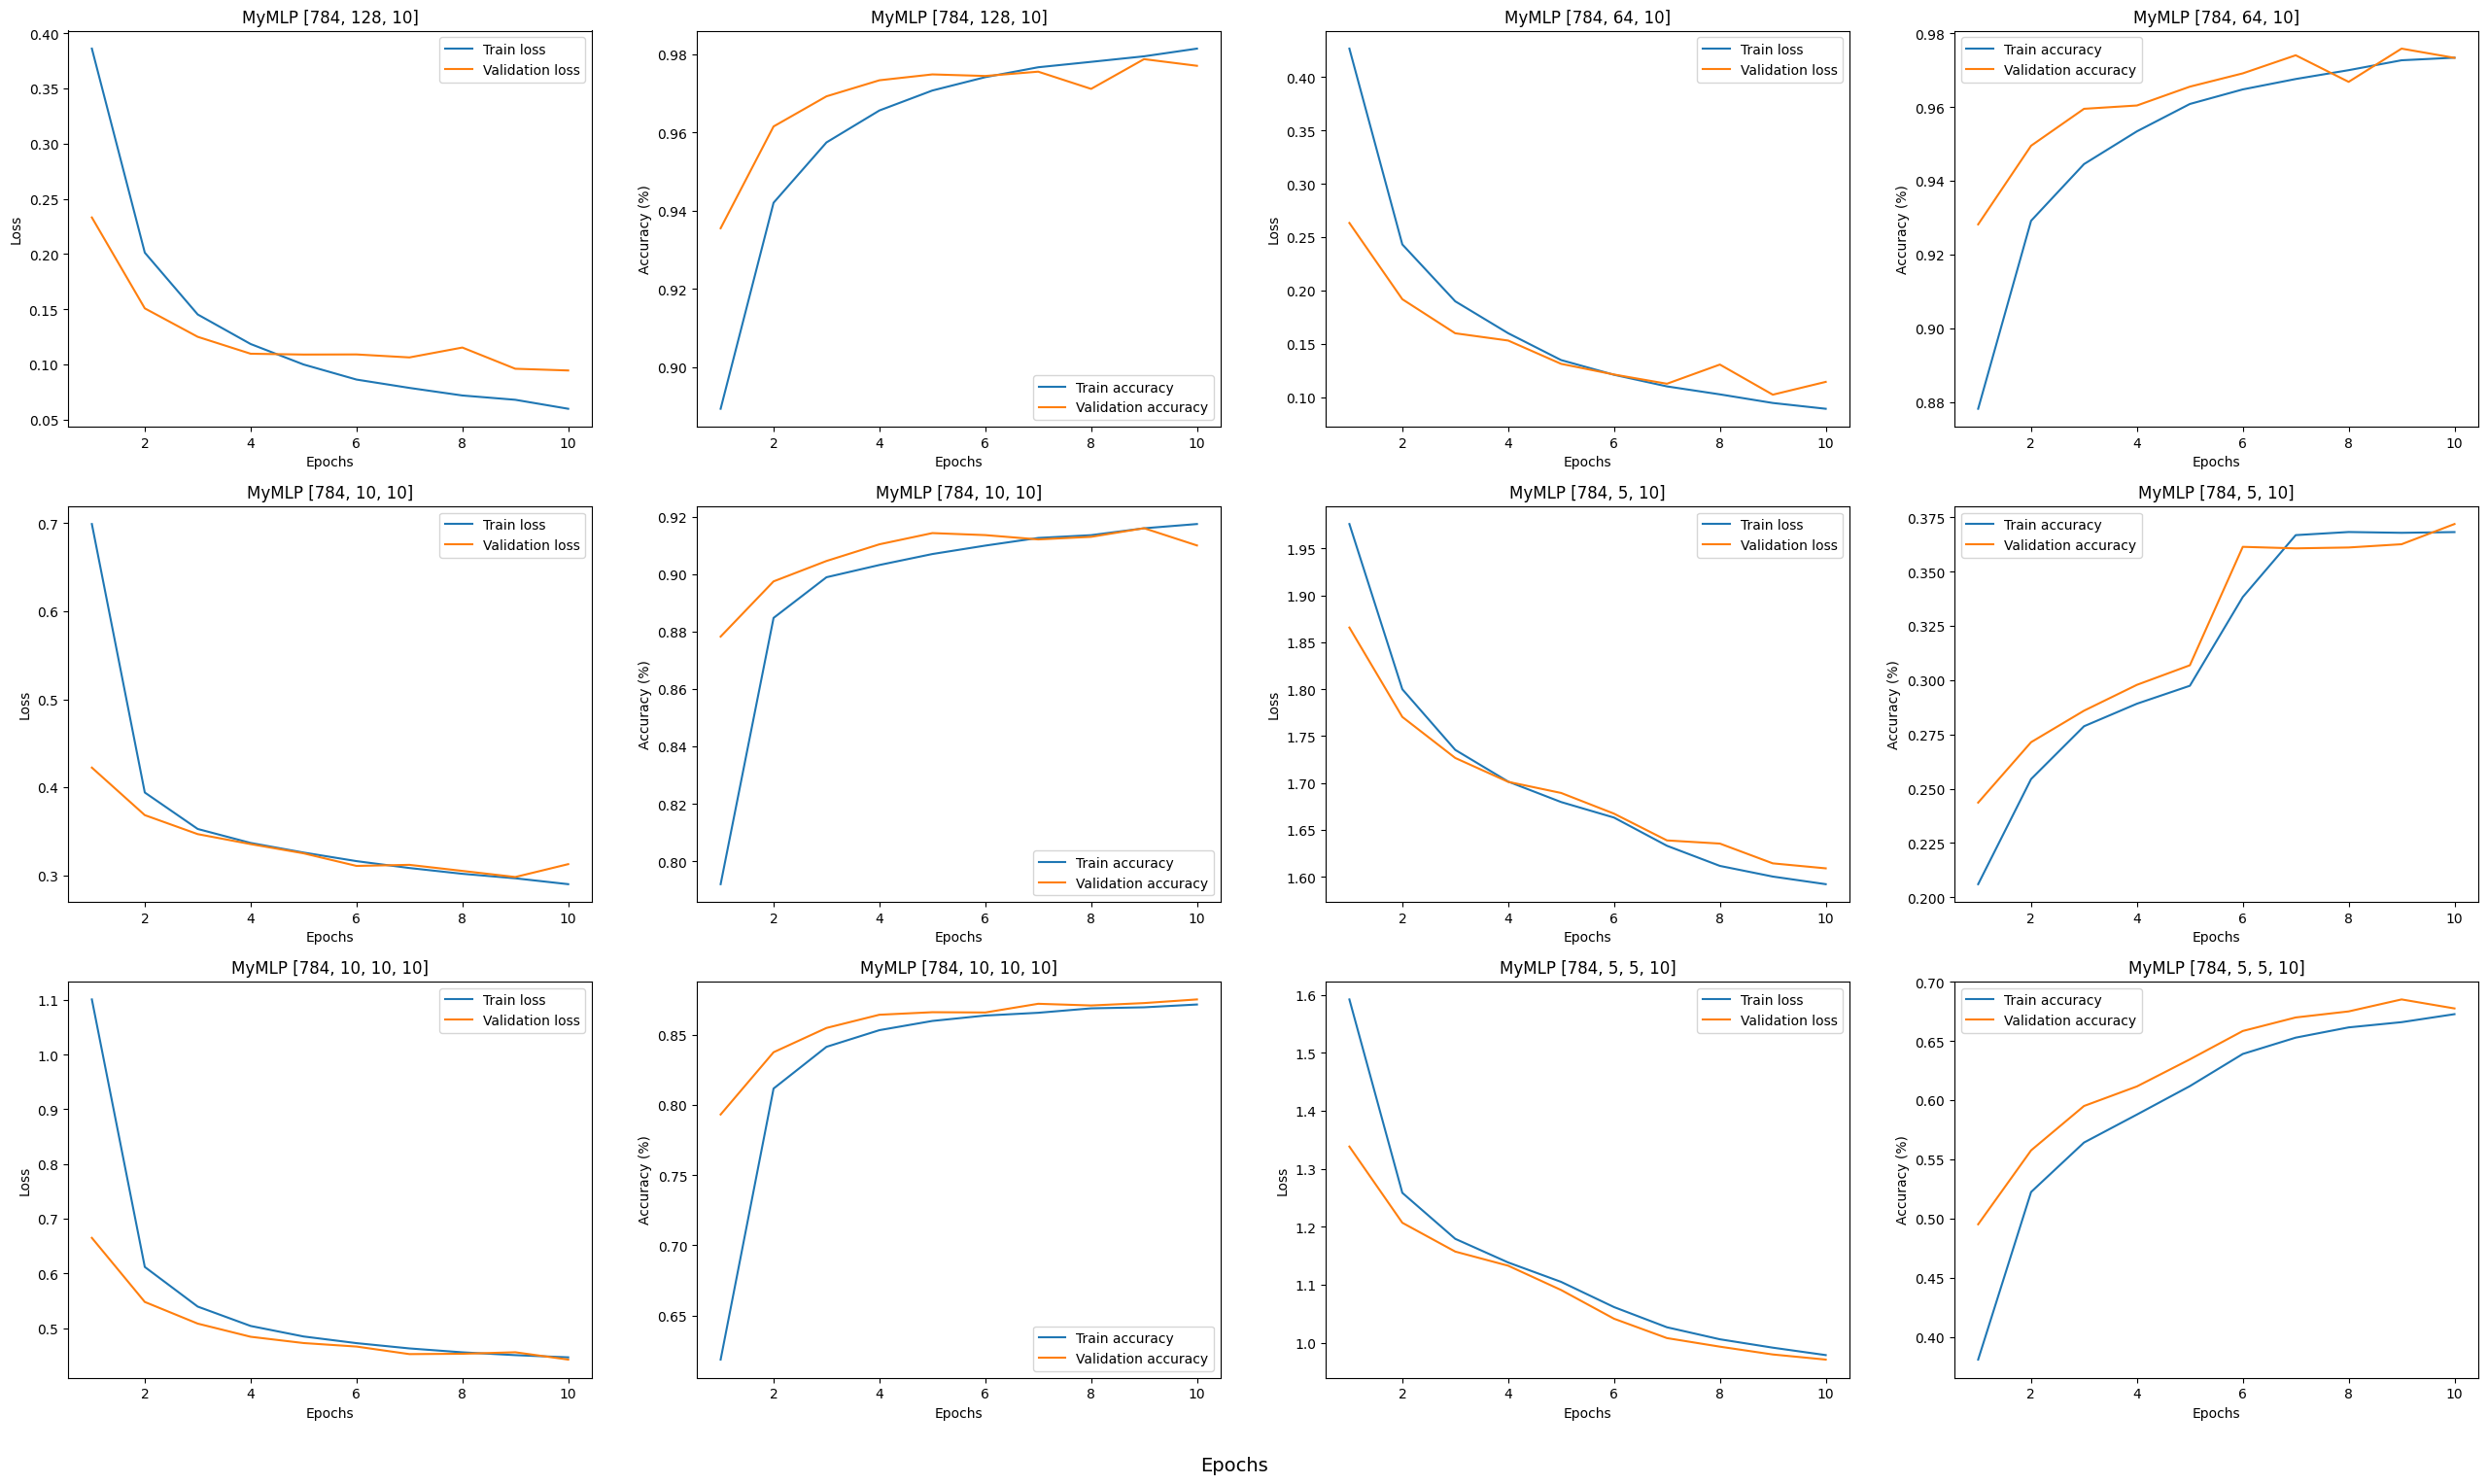

In [11]:
display_plots(model_list_mlp, total_train_losses_mlp, total_val_losses_mlp, total_train_accs_mlp, total_val_accs_mlp)

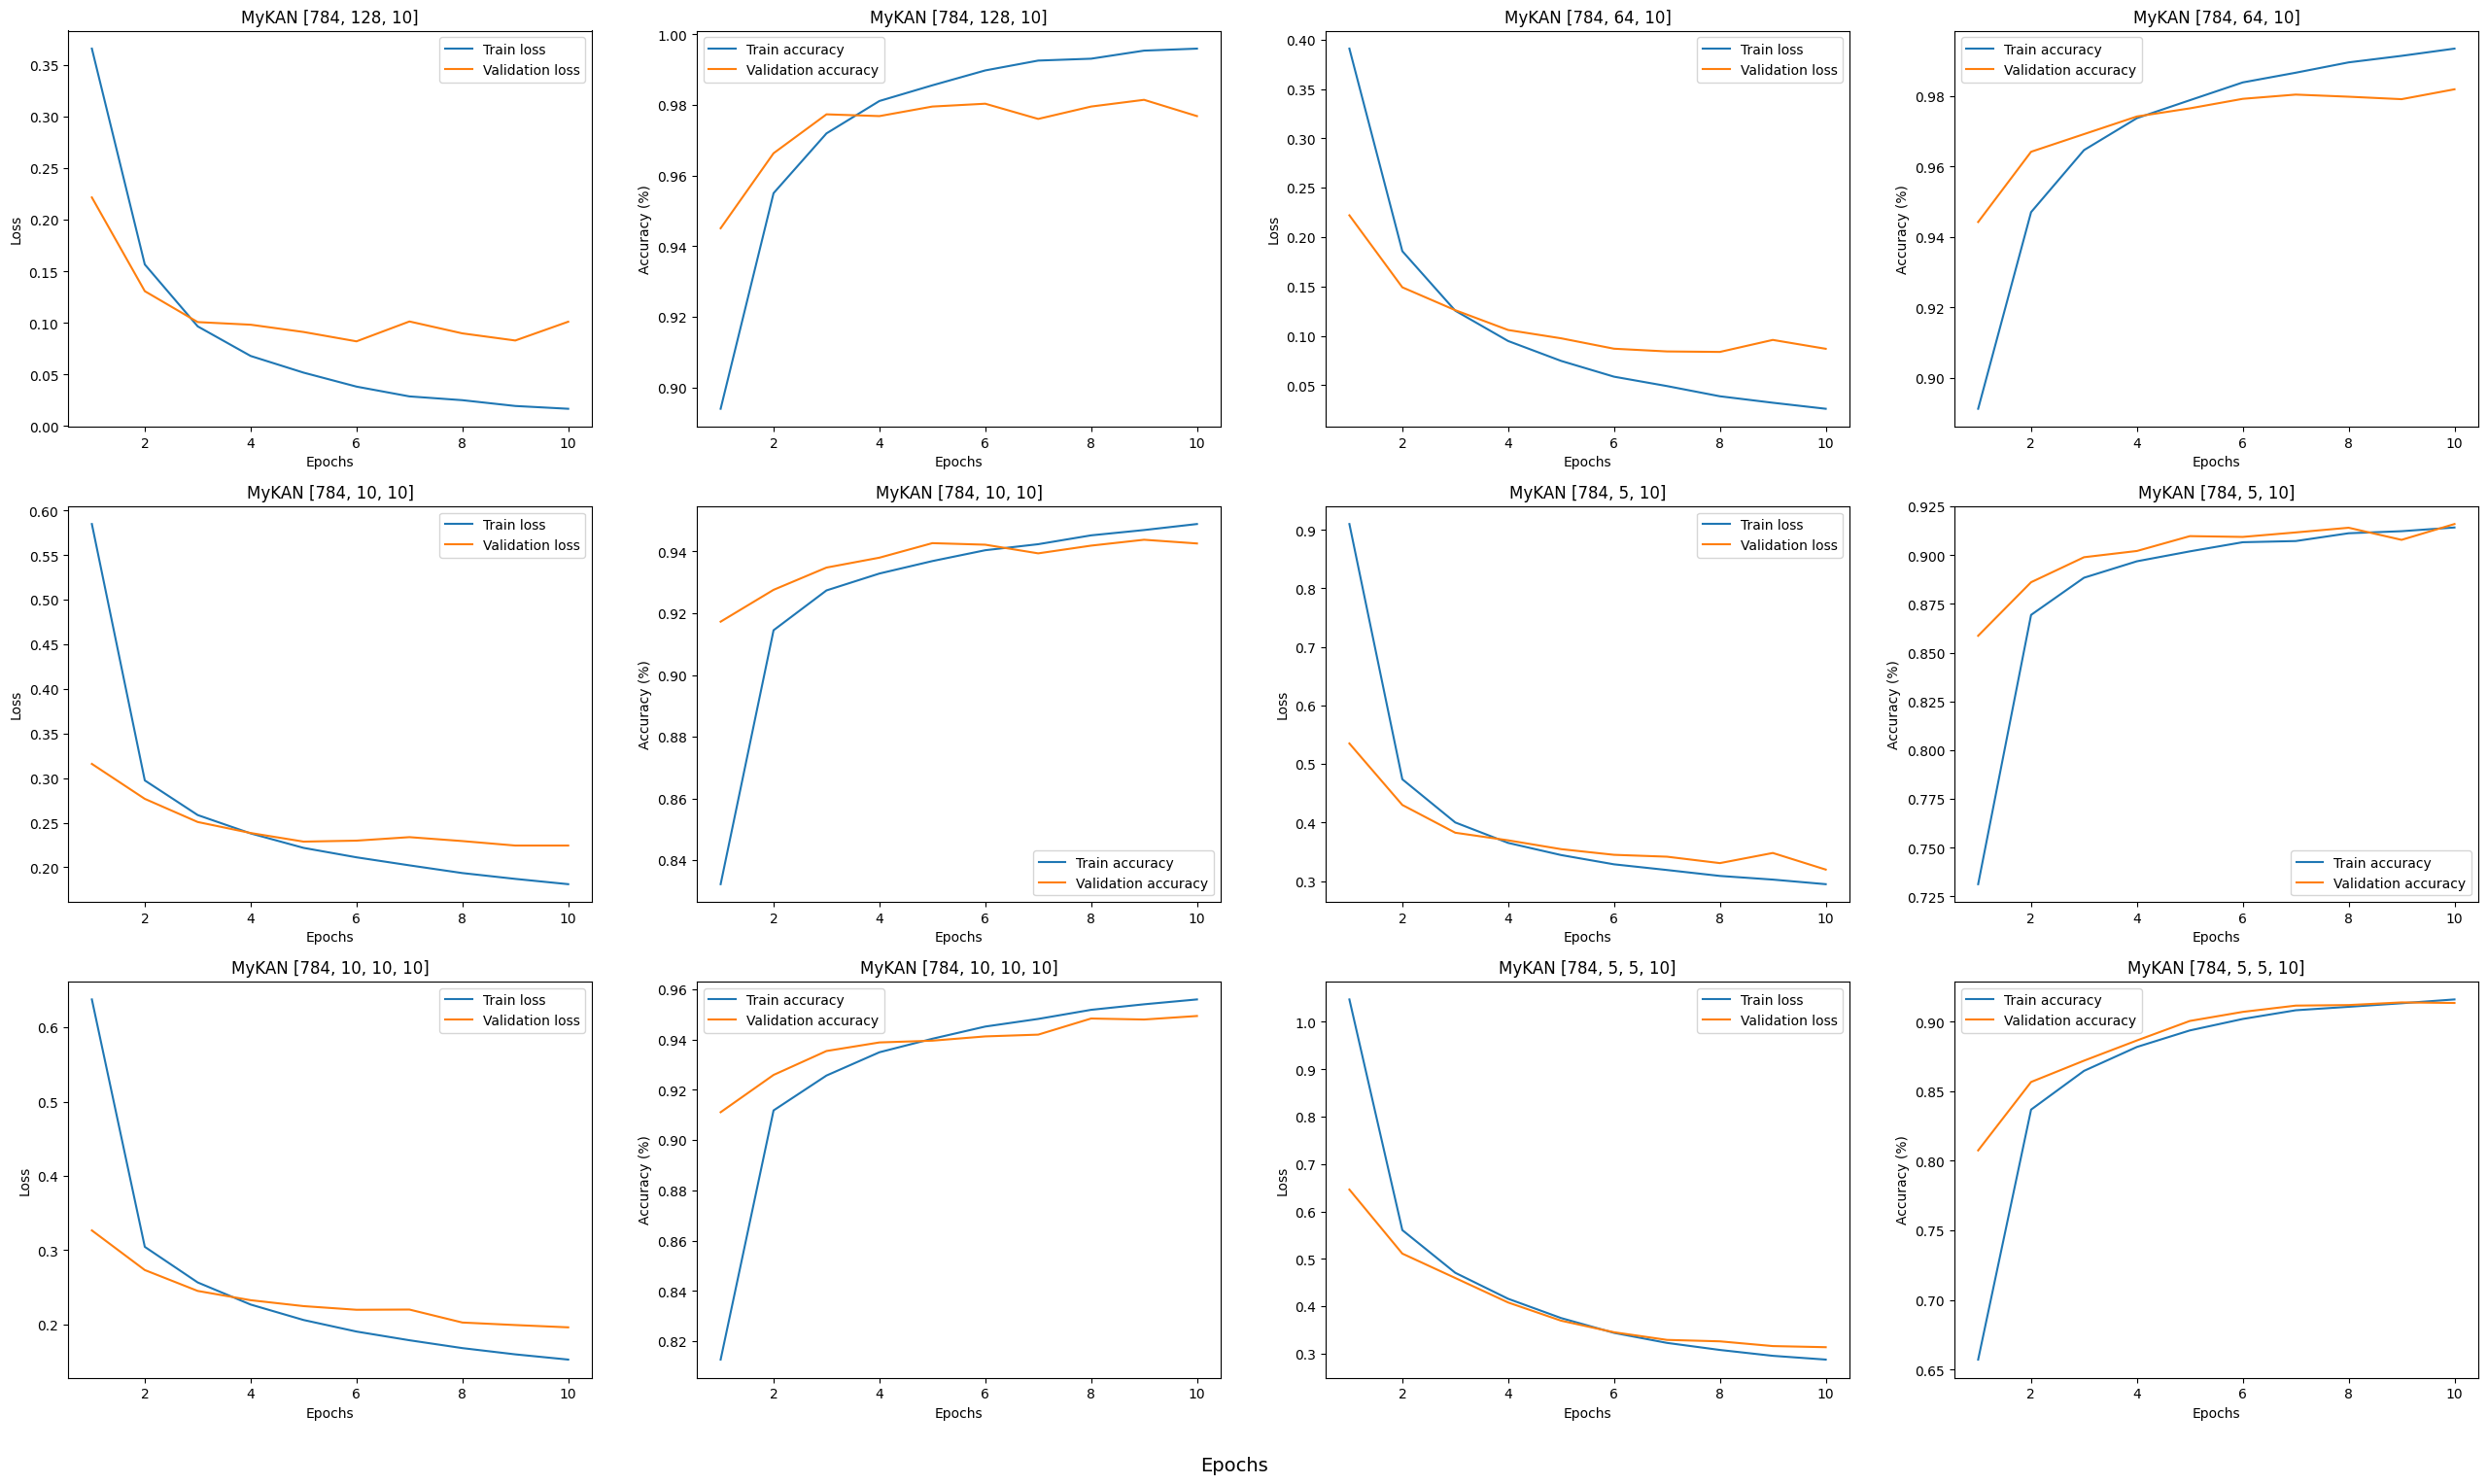

In [12]:
display_plots(model_list_kan, total_train_losses_kan, total_val_losses_kan, total_train_accs_kan, total_val_accs_kan)